In [1]:
import matplotlib.pyplot as plt
import numpy as np
from warnings import filterwarnings
import torch
import torchkbnufft as tkbn

In [2]:
echo_time = 4e-4
#fov in cm
fov_x = 5
fov_y = fov_x
fov_z = fov_x
t1_myelin = 4.0e-1 
t1_wm = 8.5e-1      
t2_myelin = 5.0e-2  
t2_wm = 5.0e-2     
t2_star_myelin = 3.0e-2  
t2_star_wm = 7.0e-2    
inv_time = np.log(2)*t1_wm
    

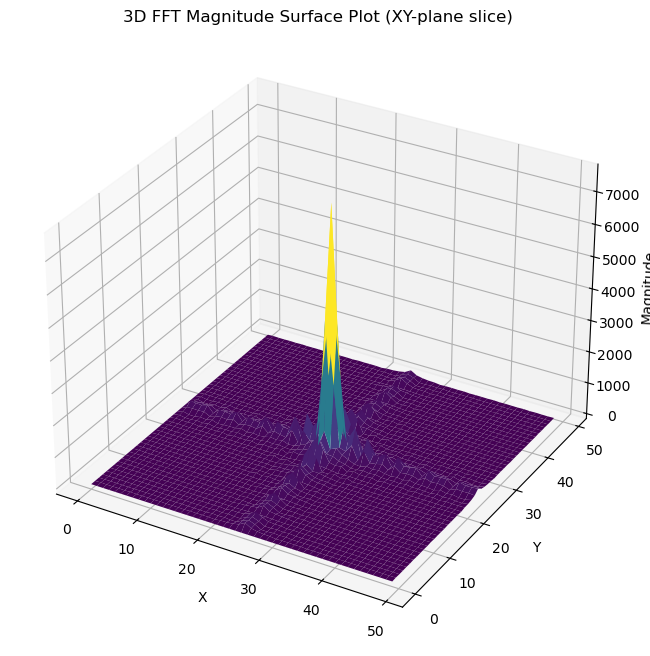

In [3]:
#res in cm
res = 0.1

pixels_x = int(fov_x/res)
pixels_y = int(fov_y/res)
pixels_z = int(fov_z/res)

mxy_myelin = (1-2*np.exp(-(inv_time/t1_myelin)))*np.exp(-(echo_time/t2_star_myelin))
mxy_wm = (1-2*np.exp(-(inv_time/t1_wm)))*np.exp(-(echo_time/t2_star_wm))
mxy_mixed = 0.5*((1-2*np.exp(-(inv_time/t1_wm)))*np.exp(-(echo_time/t2_star_wm))) + 0.5*((1-2*np.exp(-(inv_time/t1_myelin)))*np.exp(-(echo_time/t2_star_myelin)))

# Initialize 3D image
image_3d = np.ones((pixels_x, pixels_y, pixels_z))

# Define cube sizes
outer_cube_size = int(1.0 * pixels_x)
middle_cube_size = int(0.6 * pixels_x)
inner_cube_size = int(0.25 * pixels_x)

# Calculate starting and ending indices for each cube
def get_cube_bounds(size, pixels):
    start = (pixels - size) // 2
    end = start + size
    return start, end

outer_start, outer_end = get_cube_bounds(outer_cube_size, pixels_x)
middle_start, middle_end = get_cube_bounds(middle_cube_size, pixels_x)
inner_start, inner_end = get_cube_bounds(inner_cube_size, pixels_x)

# Assign intensity values
image_3d[outer_start:outer_end, outer_start:outer_end, outer_start:outer_end] = mxy_wm  # Outer cube
image_3d[middle_start:middle_end, middle_start:middle_end, middle_start:middle_end] = mxy_mixed  # Middle cube
image_3d[inner_start:inner_end, inner_start:inner_end, inner_start:inner_end] = mxy_myelin  # Inner cube
    

# # Visualization
# fig = plt.figure(figsize=(8, 8))
# ax = fig.add_subplot(111, projection='3d')

# # Normalize the intensities for colormap
# norm = colors.Normalize(vmin=np.min(image_3d), vmax=np.max(image_3d))

# # Use a colormap, for example, 'viridis'
# colormap = cm.viridis

# # Map the intensities to colors using the colormap
# colors_3d = colormap(norm(image_3d))

# # Display the entire 3D voxel grid with transparency and colormap
# # Use alpha for transparency
# voxels = ax.voxels(image_3d > 0, facecolors=colors_3d, edgecolors='black', alpha=0.3)  # Adjust alpha for transparency

# # Add a colorbar to the plot
# cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=colormap), ax=ax, shrink=0.6)
# cbar.set_label('Intensity')

# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# plt.title("3D Visualization of Nested Cubes with Transparency")

# plt.show()

# Compute the 3D FFT
fft_3d = np.fft.fftn(image_3d)

# Shift the FFT to center the zero frequency
fft_3d_shifted = np.fft.fftshift(fft_3d)

# Compute the magnitude of the FFT
magnitude = np.abs(fft_3d_shifted)

# Visualization of the 3D FFT magnitude using a 2D slice view
# We will show a middle slice in the Z-axis for the magnitude
slice_index_z = pixels_z // 2
fft_slice = magnitude[:, :, slice_index_z]

# Here we will take a slice along the XY-plane (Z-axis) and plot it
X, Y = np.meshgrid(np.arange(pixels_x), np.arange(pixels_y))
Z = fft_slice  # Magnitude at the slice we selected

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_title("3D FFT Magnitude Surface Plot (XY-plane slice)")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Magnitude')
plt.show()
image = image_3d

In [4]:
filterwarnings("ignore") # ignore floor divide warnings
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


In [5]:
# convert the phantom to a tensor and unsqueeze coil and batch dimension
image_t = torch.tensor(image).to(device).unsqueeze(0).unsqueeze(0)
print('image shape: {}'.format(image_t.shape))
im_size = image.shape
grid_size = (tuple(int(dim * 2) for dim in im_size))
print(im_size,grid_size)

image shape: torch.Size([1, 1, 50, 50, 50])
(50, 50, 50) (100, 100, 100)


7853 50
(3, 392650)
(3, 392650)


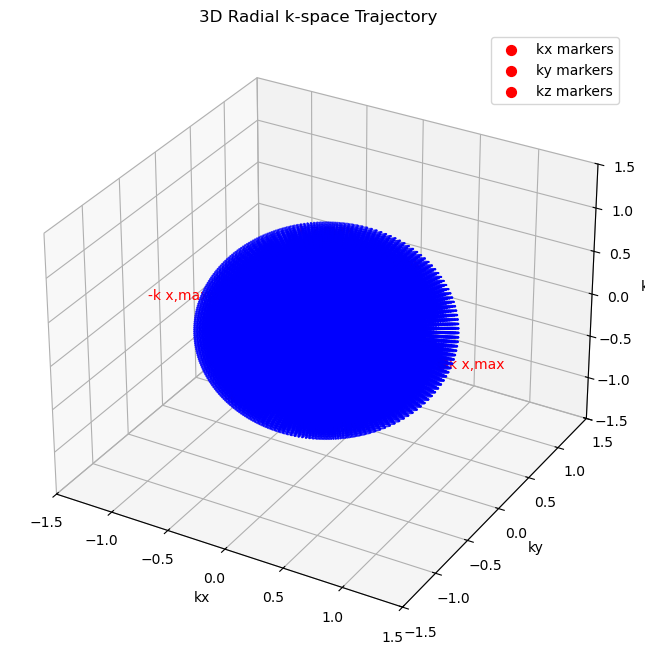

In [6]:
#res in mm and pixels
res_mm = 0.5
max_radii = 0.5/res_mm
dis_points = 1/pixels_x
nspokes = int(np.pi*(pixels_x**2))  # Number of rays
#nspokes = int((4/3)*(max_radii**3)*(pixels_x**2)) 
#nspokes = 1000
num_samples = int(max_radii*pixels_x) # Number of samples per ray
print(nspokes,num_samples)

def distribute_spokes(nspokes, num_samples, radius):
    """
    Distributes `num_spokes` evenly on a sphere and generates `num_samples` points along each spoke.
 
    Args:
        num_spokes (int): Number of spokes (directions)
        num_samples (int): Number of points along each spoke
        radius (float): Maximum radius of the sphere
 
    Returns:
        kx, ky, kz (arrays of shape (num_spokes, num_samples)): Coordinates of points along the spokes
    """
    # Fibonacci lattice for even distribution
    indices = np.arange(0, nspokes)
    phi = np.arccos(1 - 2 * (indices + 0.5) / nspokes)  # Polar angle
    theta = np.pi * (1 + 5**0.5) * indices  # Azimuthal angle
 
    # Convert to Cartesian unit vectors (direction of each spoke)
    kx_spoke = np.sin(phi) * np.cos(theta)
    ky_spoke = np.sin(phi) * np.sin(theta)
    kz_spoke = np.cos(phi)
 
    # Sample points along each spoke from the origin to the given radius
    t = np.linspace(0, radius, num_samples)  # Scale factor for each point along the spoke
 
    kx = np.outer(kx_spoke, t)
    ky = np.outer(ky_spoke, t)
    kz = np.outer(kz_spoke, t)
 
    return kx, ky, kz
  
def plot_spokes(kx, ky, kz, radius):
    """Visualizes the distributed spokes in 3D space with a correctly scaled reference sphere."""
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    num_spokes = kx.shape[0]
    
    for i in range(num_spokes):
        ax.plot(kx[i], ky[i], kz[i], marker='o', label=f"Spoke {i+1}")  # Plot each spoke
 
    # Generate a properly scaled reference sphere
    u, v = np.mgrid[0:2*np.pi:30j, 0:np.pi:15j]
    xs = radius * np.cos(u) * np.sin(v)
    ys = radius * np.sin(u) * np.sin(v)
    zs = radius * np.cos(v)
    ax.plot_wireframe(xs, ys, zs, color='gray', alpha=0.3)  # Wireframe sphere
    
    # Labels and settings
    ax.set_xlabel("kx")
    ax.set_ylabel("ky")
    ax.set_zlabel("kz")
    ax.set_title("3D Visualization of Spokes on a Sphere")
    ax.legend()
    plt.show()

kx_values, ky_values, kz_values = distribute_spokes(nspokes, num_samples, max_radii)
# plot_spokes(kx_values, ky_values, kz_values, max_radii)
 
ktraj = np.stack((kx_values.flatten(), ky_values.flatten(), kz_values.flatten()), axis=0)
print(ktraj.shape)

# Find min and max values across all axes
k_min = np.min(ktraj)
k_max = np.max(ktraj)

# Scale to [-pi, pi]
ktraj_scaled = (ktraj - k_min) / (k_max - k_min) * (2 * np.pi) - np.pi
ktraj = ktraj_scaled
print(ktraj.shape)

# # Visualize the 3D radial k-space sampling points (this shows the rays)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the sampled k-space points
ax.scatter(kx_values, ky_values, kz_values, c='b', marker='.', s=1)

# Set the plot limits to ensure that the center is visible
padding = 0.5 * max_radii  # 10% of max_radii for padding
ax.set_xlim([-max_radii - padding, max_radii + padding])
ax.set_ylim([-max_radii - padding, max_radii + padding])
ax.set_zlim([-max_radii - padding, max_radii + padding])

# Plot markers on the axes at kmax and -kmax
ax.scatter([max_radii, -max_radii], [0, 0], [0, 0], color='r', label='kx markers', s=50)  # Markers along x-axis
ax.scatter([0, 0], [max_radii, -max_radii], [0, 0], color='r', label='ky markers', s=50)  # Markers along y-axis
ax.scatter([0, 0], [0, 0], [max_radii, -max_radii], color='r', label='kz markers', s=50)  # Markers along z-axis

# Add text labels near the markers with offsets
text_offset = 0.05 * max_radii  # Offset for the text relative to the marker
ax.text(max_radii + text_offset, 0, 0, 'k x,max', color='red', fontsize=10, ha='left', va='center')  # x-axis positive
ax.text(-max_radii - text_offset, 0, 0, '-k x,max', color='red', fontsize=10, ha='right', va='center')  # x-axis negative
ax.text(0, max_radii + text_offset, 0, 'k y,max', color='red', fontsize=10, ha='center', va='bottom')  # y-axis positive
ax.text(0, -max_radii - text_offset, 0, '-k y,max', color='red', fontsize=10, ha='center', va='top')  # y-axis negative
ax.text(0, 0, max_radii + text_offset, 'k z,max', color='red', fontsize=10, ha='center', va='bottom')  # z-axis positive
ax.text(0, 0, -max_radii - text_offset, '-k z,max', color='red', fontsize=10, ha='center', va='top')  # z-axis negative

# Add the legend
ax.legend()

# Add labels and title
ax.set_title('3D Radial k-space Trajectory')
ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_zlabel('kz')

# Display the plot
plt.show()


In [7]:
# convert k-space trajectory to a tensor
ktraj = torch.tensor(ktraj).to(device)
print('ktraj shape: {}'.format(ktraj.shape))

ktraj shape: torch.Size([3, 392650])


In [8]:
# create NUFFT objects, use 'ortho' for orthogonal FFTs
nufft_ob = tkbn.KbNufft(
    im_size=im_size,
    grid_size=grid_size,
).to(image_t)
adjnufft_ob = tkbn.KbNufftAdjoint(
    im_size=im_size,
    grid_size=grid_size,
).to(image_t)

print(nufft_ob)
print(adjnufft_ob)


KbNufft
----------------------------------------
buffers
	tensor: table_0, shape: (6145,)
	tensor: table_1, shape: (6145,)
	tensor: table_2, shape: (6145,)
	tensor: im_size, shape: (3,)
	tensor: grid_size, shape: (3,)
	tensor: n_shift, shape: (3,)
	tensor: numpoints, shape: (3,)
	tensor: offsets, shape: (216, 3)
	tensor: table_oversamp, shape: (3,)
	tensor: order, shape: (3,)
	tensor: alpha, shape: (3,)
	tensor: scaling_coef, shape: (50, 50, 50)


KbNufftAdjoint
----------------------------------------
buffers
	tensor: table_0, shape: (6145,)
	tensor: table_1, shape: (6145,)
	tensor: table_2, shape: (6145,)
	tensor: im_size, shape: (3,)
	tensor: grid_size, shape: (3,)
	tensor: n_shift, shape: (3,)
	tensor: numpoints, shape: (3,)
	tensor: offsets, shape: (216, 3)
	tensor: table_oversamp, shape: (3,)
	tensor: order, shape: (3,)
	tensor: alpha, shape: (3,)
	tensor: scaling_coef, shape: (50, 50, 50)



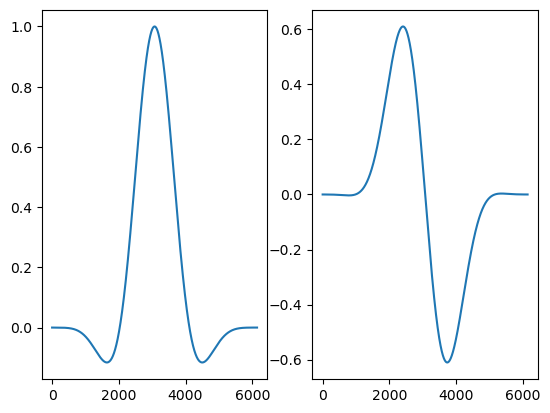

In [9]:
# plot the kernel
fig, axs = plt.subplots(1, 2)
axs.flat[0].plot(np.real(nufft_ob.table_0.cpu().numpy()))
axs.flat[1].plot(np.imag(nufft_ob.table_0.cpu().numpy()))
    
plt.show()

In [10]:
#print(image_t.shape)

# Convert image_t to complex if it's real (with last dimension not equal to 2)
if image_t.ndimension() == 3 and image_t.shape[-1] != 2:  # Real input
    print("Converting real image to complex...")
    image_t = torch.stack([image_t, torch.zeros_like(image_t)], dim=-1)  # Convert to complex

#print(image_t.shape)

# Check the dtype of image_t
#print(image_t.dtype)

# If it's real, convert it to complex
if image_t.dtype != torch.complex128:
    print("Converting image to complex dtype...")
    image_t = image_t.to(torch.complex128)  # Convert to complex type

# Now pass the image to the nufft_ob function
kdata = nufft_ob(image_t, ktraj)

# add some noise (robustness test)
#siglevel = torch.abs(kdata).mean()
#kdata = kdata + (siglevel/5) * torch.randn(kdata.shape).to(kdata)
print(kdata.shape)

Converting image to complex dtype...
torch.Size([1, 1, 392650])


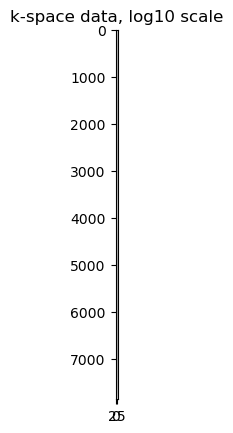

torch.Size([3, 392650])


In [11]:
# plot the k-space data on log-scale
kdata_numpy = np.reshape(kdata.cpu().numpy(), (nspokes,num_samples))
plt.imshow(np.log10(np.absolute(kdata_numpy)))
plt.gray()
plt.title('k-space data, log10 scale')
plt.show()
print(ktraj.shape)

In [12]:
# adjnufft back
# method 1: no density compensation (blurry image)
image_blurry = adjnufft_ob(kdata, ktraj)


# method 2: use density compensation
dcomp = tkbn.calc_density_compensation_function(ktraj=ktraj, im_size=im_size)
image_sharp = adjnufft_ob(kdata * dcomp, ktraj)




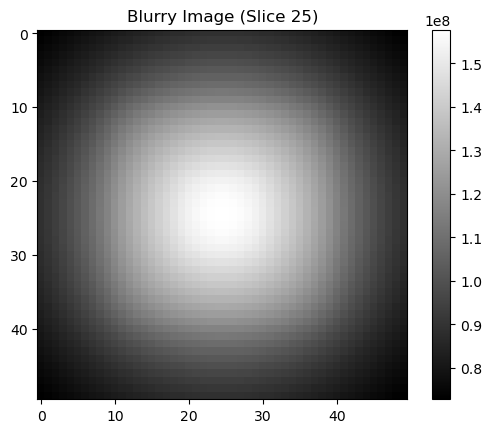

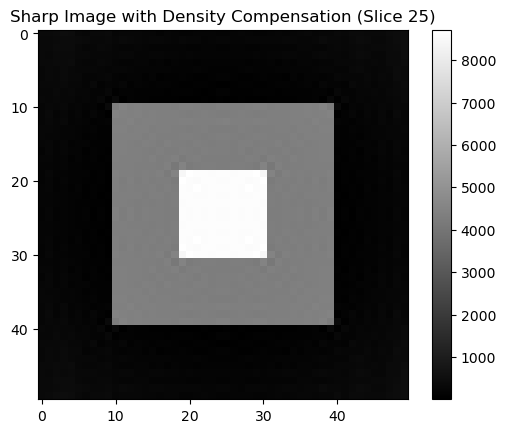

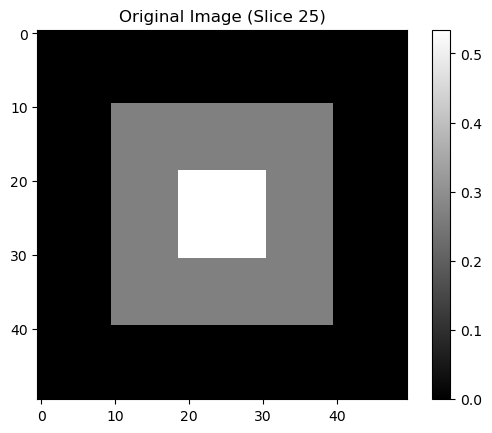

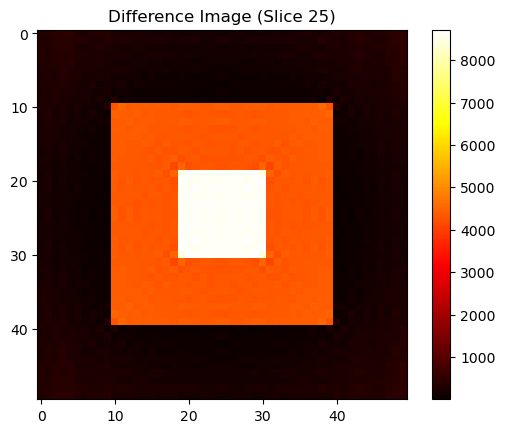

In [13]:
# show the images
image_blurry_numpy = np.squeeze(image_blurry.cpu().numpy())

image_sharp_numpy = np.squeeze(image_sharp.cpu().numpy())

image_numpy = np.squeeze(image)  # Original image as numpy

# Choose a slice to display (e.g., the middle slice in the z-axis)
slice_idx = image_numpy.shape[0] // 2

# Display the images
plt.figure(0)
plt.imshow(np.abs(image_blurry_numpy[slice_idx, :, :]), cmap='gray')
plt.colorbar()
plt.title(f'Blurry Image (Slice {slice_idx})')

plt.figure(1)
plt.imshow(np.abs(image_sharp_numpy[slice_idx, :, :]), cmap='gray')
plt.colorbar()
plt.title(f'Sharp Image with Density Compensation (Slice {slice_idx})')

plt.figure(2)
plt.imshow(np.abs(image[slice_idx, :, :]), cmap='gray')
plt.colorbar()
plt.title(f'Original Image (Slice {slice_idx})')

# Calculate the difference image
diff_image = np.abs(image_sharp - image)
diff_image = np.squeeze(diff_image)
plt.figure(3)
plt.imshow(np.abs(diff_image[slice_idx, :, :]), cmap='hot')
plt.colorbar()
plt.title(f'Difference Image (Slice {slice_idx})')

# Display the images
plt.savefig("result")
plt.show()